<a href="https://colab.research.google.com/github/thedavidemmanuel/BTC-Time-Series-Forecasting/blob/main/btc_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from google.colab import drive
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.regularizers import l2

In [22]:
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
# Define file paths
bitstamp_path = '/content/drive/MyDrive/BTC Model/bitstampUSD_1-min_data_2012-01-01_to_2020-04-22.csv'
coinbase_path = '/content/drive/MyDrive/BTC Model/coinbaseUSD_1-min_data_2014-12-01_to_2019-01-09.csv'


In [4]:
# Load the data
def load_data(file_path):
    print(f"Loading data from: {file_path}")
    data = pd.read_csv(file_path, on_bad_lines='skip', low_memory=False)
    print(f"Data loaded successfully. Shape: {data.shape}")
    return data

bitstamp_data = load_data(bitstamp_path)
coinbase_data = load_data(coinbase_path)

Loading data from: /content/drive/MyDrive/BTC Model/bitstampUSD_1-min_data_2012-01-01_to_2020-04-22.csv
Data loaded successfully. Shape: (4363457, 8)
Loading data from: /content/drive/MyDrive/BTC Model/coinbaseUSD_1-min_data_2014-12-01_to_2019-01-09.csv
Data loaded successfully. Shape: (2099760, 8)


In [5]:
# Preprocess data
def preprocess_data(data):
    print("Preprocessing data...")
    data['Volume_(BTC)'] = pd.to_numeric(data['Volume_(BTC)'], errors='coerce')
    data = data.ffill()  # Use ffill() instead of fillna(method='ffill')
    data = data.dropna()
    print(f"Preprocessing complete. New shape: {data.shape}")
    return data

def set_timestamp_index(data):
    print("Setting timestamp as index...")
    data['Timestamp'] = pd.to_datetime(data['Timestamp'], unit='s')
    data = data.set_index('Timestamp')
    print("Timestamp set as index.")
    return data

def resample_hourly(data):
    print("Resampling to hourly data...")
    data_hourly = data.resample('H').mean()
    data_hourly = data_hourly.ffill()  # Use ffill() instead of fillna(method='ffill')
    print(f"Resampling complete. New shape: {data_hourly.shape}")
    return data_hourly

In [6]:
# Apply preprocessing steps
bitstamp_data = preprocess_data(bitstamp_data)
coinbase_data = preprocess_data(coinbase_data)

bitstamp_data = set_timestamp_index(bitstamp_data)
coinbase_data = set_timestamp_index(coinbase_data)

bitstamp_data_hourly = resample_hourly(bitstamp_data)
coinbase_data_hourly = resample_hourly(coinbase_data)

Preprocessing data...
Preprocessing complete. New shape: (4363457, 8)
Preprocessing data...
Preprocessing complete. New shape: (2099760, 8)
Setting timestamp as index...
Timestamp set as index.
Setting timestamp as index...
Timestamp set as index.
Resampling to hourly data...
Resampling complete. New shape: (72834, 7)
Resampling to hourly data...
Resampling complete. New shape: (35970, 7)


In [7]:
# Combine the datasets
print("Combining datasets...")
combined_data = pd.concat(
    [bitstamp_data_hourly['Close'], coinbase_data_hourly['Close']],
    axis=1,
    join='inner'
)
combined_data.columns = ['Bitstamp_Close', 'Coinbase_Close']
combined_data['Average_Close'] = combined_data.mean(axis=1)
print(f"Datasets combined. Shape: {combined_data.shape}")


Combining datasets...
Datasets combined. Shape: (35970, 3)


Scaling the data...
Data scaling complete.

Combined Data Head:
                     Bitstamp_Close  Coinbase_Close  Average_Close
Timestamp                                                         
2014-12-01 05:00:00      378.437167           300.0     339.218583
2014-12-01 06:00:00      380.137333           342.0     361.068667
2014-12-01 07:00:00      380.184667           370.0     375.092333
2014-12-01 08:00:00      377.959000           370.0     373.979500
2014-12-01 09:00:00      377.931333           370.0     373.965667

Scaled Data Head:
[[0.00993824]
 [0.01105503]
 [0.0117718 ]
 [0.01171492]
 [0.01171421]]


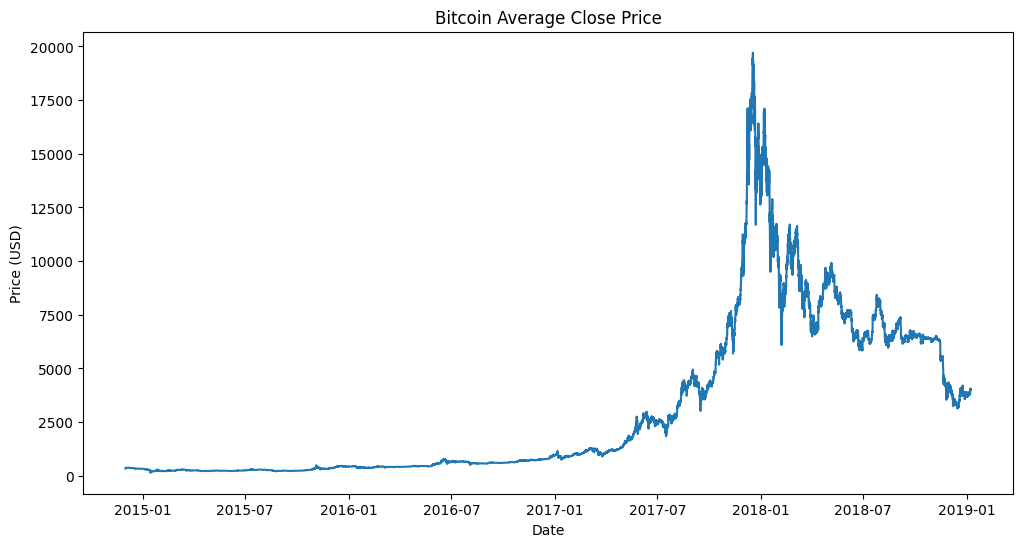

In [8]:
# Scale the data
print("Scaling the data...")
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(combined_data[['Average_Close']])
print("Data scaling complete.")

# Display results
print("\nCombined Data Head:")
print(combined_data.head())
print("\nScaled Data Head:")
print(scaled_data[:5])

# Visualize the data
plt.figure(figsize=(12, 6))
plt.plot(combined_data.index, combined_data['Average_Close'])
plt.title('Bitcoin Average Close Price')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.show()

In [15]:
# Split the data into training and testing sets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

In [41]:
# Create sequences for the LSTM model
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        target = data[i+seq_length]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

seq_length = 24  # Use 24 hours of data to predict the next hour
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

In [17]:
# Reshape input data for LSTM [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [42]:
# Data Augmentation Function
def add_noise(X, noise_factor=0.005):
    noise = np.random.normal(loc=0, scale=noise_factor, size=X.shape)
    return X + noise

# Apply data augmentation
X_train_augmented = add_noise(X_train)
X_train_combined = np.concatenate([X_train, X_train_augmented])
y_train_combined = np.concatenate([y_train, y_train])

In [46]:
# Feature Engineering: Adding a simple moving average
def add_moving_average(X, window=5):
    ma = np.array([np.mean(X[i:i+window], axis=0) for i in range(X.shape[0] - window + 1)])
    ma = np.pad(ma, ((window-1, 0), (0, 0), (0, 0)), mode='edge')
    return np.concatenate([X, ma], axis=-1)

X_train_combined = add_moving_average(X_train_combined)
X_test = add_moving_average(X_test)

print("Shape of X_train_combined:", X_train_combined.shape)
print("Shape of y_train_combined:", y_train_combined.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train_combined: (57504, 24, 2)
Shape of y_train_combined: (57504, 1)
Shape of X_test: (7170, 24, 2)
Shape of y_test: (7170, 1)


In [43]:
# Create tf.data.Dataset
def create_dataset(X, y, batch_size=32, shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    dataset = dataset.shuffle(buffer_size=shuffle_buffer)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

train_dataset = create_dataset(X_train_combined, y_train_combined)
test_dataset = create_dataset(X_test, y_test, shuffle_buffer=1)  # No shuffling for test data


In [44]:
# Build the LSTM model with increased regularization
model = Sequential([
    LSTM(24, activation='relu', return_sequences=True,
         input_shape=(X_train_combined.shape[1], X_train_combined.shape[2]),
         kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01)),
    Dropout(0.3),
    LSTM(24, activation='relu', kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01)),
    Dropout(0.3),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 24, 24)              │           2,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 24, 24)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 24)                  │           4,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 24)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              25 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,225 (28.22 KB)

 Trainable params: 7,225 (28.22 KB)

 Non-trainable params: 0 (0.00 B)

In [45]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)


In [47]:
# Train the model using tf.data.Dataset
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=test_dataset,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/50
1797/1797 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - loss: 0.1322 - val_loss: 0.0148 - learning_rate: 0.0010
Epoch 2/50
1797/1797 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - loss: 0.0188 - val_loss: 0.0096 - learning_rate: 0.0010
Epoch 3/50
1797/1797 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 0.0346 - val_loss: 0.0067 - learning_rate: 0.0010
Epoch 4/50
1797/1797 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - loss: 0.0323 - val_loss: 0.0065 - learning_rate: 0.0010
Epoch 5/50
1797/1797 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 0.0320 - val_loss: 0.0064 - learning_rate: 0.0010
Epoch 6/50
1797/1797 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - loss: 0.0317 - val_loss: 0.0064 - learning_rate: 0.0010
Epoch 7/50
1797/1797 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 0.0319 - val_loss: 0.0064 - learning_rate: 0.0010
Epoch 8/50
1797/1797 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 0.0318 - val_loss: 0.0064 - learning_rate: 0.0010
Epoch 9/50
1797/1797 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - loss: 0.0318 - val_loss: 0.0064 - learn

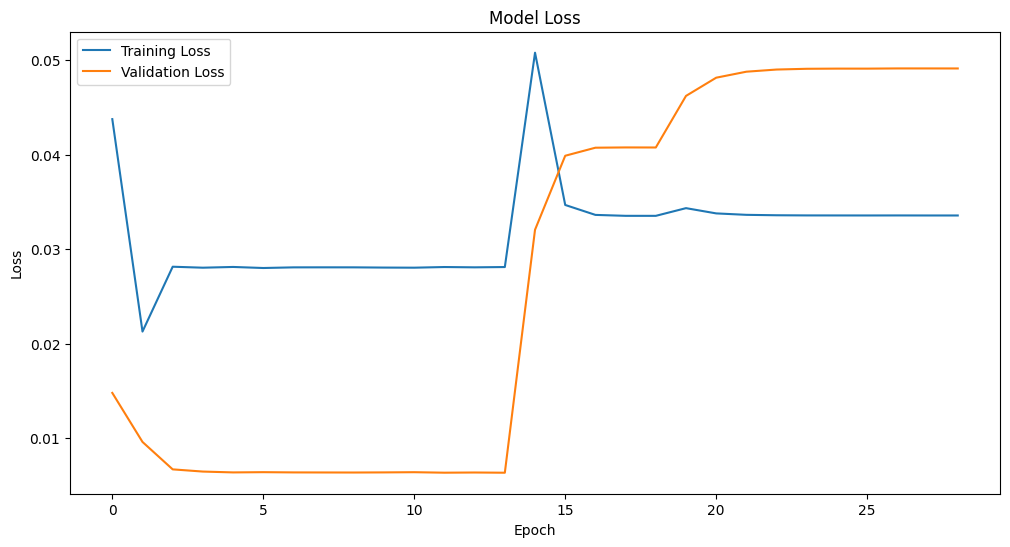

In [48]:
# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [49]:
# Evaluate the model
train_loss = model.evaluate(train_dataset, verbose=0)
test_loss = model.evaluate(test_dataset, verbose=0)
print(f'Train MSE: {train_loss:.4f}')
print(f'Test MSE: {test_loss:.4f}')

Train MSE: 0.0925
Test MSE: 0.0063


In [50]:
# Make predictions
train_predict = model.predict(train_dataset)
test_predict = model.predict(test_dataset)

1797/1797 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


In [51]:
# Inverse transform predictions and actual values
train_predict = scaler.inverse_transform(train_predict)
y_train_inv = scaler.inverse_transform(y_train_combined.reshape(-1, 1))
test_predict = scaler.inverse_transform(test_predict)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

In [52]:
# Calculate performance metrics
def calculate_metrics(actual, predicted):
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predicted)
    r2 = r2_score(actual, predicted)
    return mse, rmse, mae, r2

train_mse, train_rmse, train_mae, train_r2 = calculate_metrics(y_train_inv, train_predict)
test_mse, test_rmse, test_mae, test_r2 = calculate_metrics(y_test_inv, test_predict)

print("\nTraining Data Metrics:")
print(f"MSE: {train_mse:.2f}")
print(f"RMSE: {train_rmse:.2f}")
print(f"MAE: {train_mae:.2f}")
print(f"R2 Score: {train_r2:.4f}")

print("\nTest Data Metrics:")
print(f"MSE: {test_mse:.2f}")
print(f"RMSE: {test_rmse:.2f}")
print(f"MAE: {test_mae:.2f}")
print(f"R2 Score: {test_r2:.4f}")


Training Data Metrics:
MSE: 35409549.29
RMSE: 5950.59
MAE: 5722.07
R2 Score: -1.7689

Test Data Metrics:
MSE: 2426248.71
RMSE: 1557.64
MAE: 1156.44
R2 Score: -0.0409


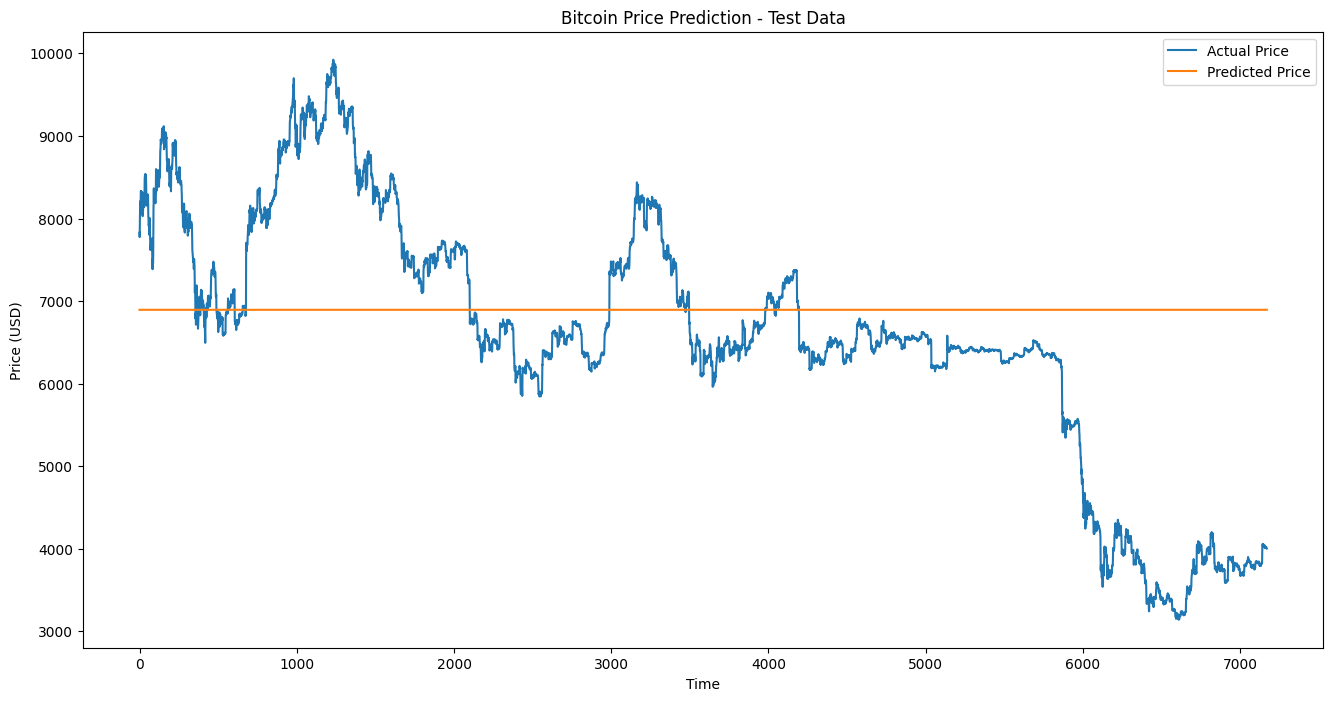

In [53]:
# Visualize predictions
plt.figure(figsize=(16, 8))
plt.plot(y_test_inv, label='Actual Price')
plt.plot(test_predict, label='Predicted Price')
plt.title('Bitcoin Price Prediction - Test Data')
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()